# Práctica 3: Introducción a PyTorch

## a) Calculando el gradiente mediante Autograd

En primer lugar, vamos a calcular del gradiente para el perceptrón simple con función de activación sigmoidea que vimos en la teoría. Pero esta vez, en lugar de realizar manualmente el proceso de backpropagation, vamos a usar el módulo `autograd` de PyTorch.

La función $f(x, w)$ a la cual queremos encontrarle el gradiente es:

> $f(\mathbf{x}, \mathbf{w}) = \frac{1}{1 + e^{2-(w_0 x_0 + w_1 x_1 + w_2)}}$

Definimos entonces la función utilizando `torch.tensor` (recordar usar el parámetro `requires_grad = True` para que PyTorch guarde los gradientes) y realizamos la pasada "forward" para los siguientes valores de x y w:

> $\mathbf{x} = (-1, -2)$

> $\mathbf{w} = (2, -3, -3)$



In [1]:
import torch

# Definimos los tensores
x = torch.tensor([-1.0, -2.0])  # x0 = -1, x1 = -2
w = torch.tensor([2.0, -3.0, -3.0], requires_grad=True)  # w0, w1, w2 con gradiente

# Cálculo del perceptrón
z = w[0] * x[0] + w[1] * x[1] + w[2]  # z = w0*x0 + w1*x1 + w2
f = 1 / (1 + torch.exp(2 - z))  # f(x, w)

print(f)


tensor(0.2689, grad_fn=<MulBackward0>)


Ahora, utilizando la función `f.backward()` computamos los gradientes $\frac{\partial f}{ \partial \mathbf{x}}$ y $\frac{\partial f}{ \partial \mathbf{w}}$

In [2]:
f.backward()

In [3]:
print("Gradiente df/dx = " + str(x.grad))
print("Gradiente df/dw = " + str(w.grad))

Gradiente df/dx = None
Gradiente df/dw = tensor([-0.1966, -0.3932,  0.1966])


## b) Minimizando una función con Gradient Descent

Ahora, vamos a implementar usar el algorítmo de gradiente descendiente (utilizando Autograd para computar el gradiente) para minimizar la función cuadrática $$f(x) = 2x^2 + x + 4$$

Utilizaremos la implementación `torch.optim.SGD` de gradiente descendiente.



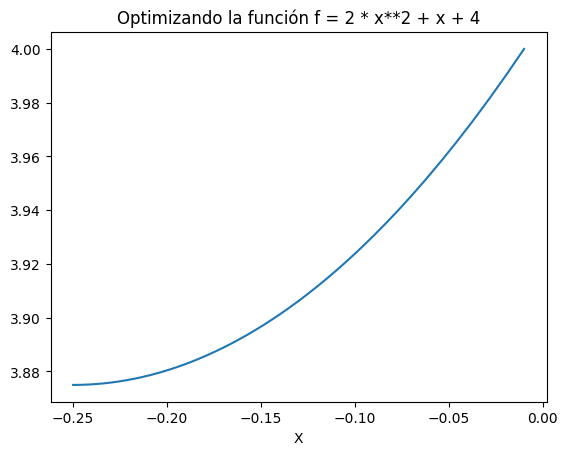

In [4]:
import matplotlib.pyplot as plt

# Definir la variable que será el parámetro a optimizar
x = torch.tensor([0.0], requires_grad=True)

# Definir el optimizador, indicando el parámetro a optimizar y el learning rate
optimizer = torch.optim.SGD([x], lr= 0.01)

# Acumuladores que usaremos para guardar los valores sucesivos de x, y
f_values = []
x_values = []

# Loop de optimización
for i in range(10000):

    # Setemos en 0 los gradientes de todos los elementos
    optimizer.zero_grad()
       
    # Pasada forward: ejecutar la función a minimizar
    f = 2 * x**2 + x + 4

    #print("X = " + str(x) + ", f(x) = " + str(f))

    # Pasada backward: computar los gradientes
    f.backward()

    # Actualizar los pesos dando un paso de gradiente descendiente
    optimizer.step()

    # Guardar los valores para luego plotearlos
    f_values.append(f.data.item())
    x_values.append(x.data.item())

# Ploteo los valores
plt.title("Optimizando la función f = 2 * x**2 + x + 4")
plt.xlabel("X")
plt.plot(x_values,f_values)


# c) Implementando un MLP en PyTorch para predicción del procentaje de grasa corporal

Contamos con una base de datos [1] de 252 mediciones del porcentaje de grasa corporal de 252 personas diferentes, el cual puede ser estimado mediante otras características, como la edad, el peso, y mediciones en diferentes partes del cuerpo. A partir de estos datos se pretende desarrollar un sistema que permita predecir dicho porcentaje a partir de las características.

[1]: Olson, R.S., La Cava, W., Orzechowski, P. et al. PMLB: a large benchmark suite for machine learning evaluation and comparison. BioData Mining 10, 36 (2017). https://epistasislab.github.io/pmlb/profile/560_bodyfat.html

Antes de comenzar, vamos a instalar el paquete de Python que contiene la base de datos:

In [ ]:
#pip install pmlb

Note: you may need to restart the kernel to use updated packages.


Ahora vamos a generar un histograma de todas las mediciones del porcentaje con todos los datos disponibles:

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from pmlb import fetch_data

# Importamos el dataset
body_fat = fetch_data('560_bodyfat')
body_fat.describe()

# Extraigo los datos (features) y los porcentajes (etiquetas a predecir)
data = body_fat.loc[:, body_fat.columns != 'target'].to_numpy()
percentages = body_fat.loc[:, body_fat.columns == 'target'].to_numpy()

data = data.astype(np.float32)
percentages = percentages.astype(np.float32)

print("Fila de ejemplo:")
print(list(body_fat.columns))
print(data[0,:])

# Dibujo un histograma del porcentaje de grasa corporal usando todos los datos
#_ = plt.hist(list(body_fat.columns), data[0,:], 50, density=True, facecolor='g', alpha=0.75)
#_ = plt.title("Porcentaje de grasa corporal")


Fila de ejemplo:
['Density', 'Age', 'Weight', 'Height', 'Neck', 'Chest', 'Abdomen', 'Hip', 'Thigh', 'Knee', 'Ankle', 'Biceps', 'Forearm', 'Wrist', 'target']
[  1.0708  23.     154.25    67.75    36.2     93.1     85.2     94.5
  59.      37.3     21.9     32.      27.4     17.1   ]


Particionamos los datos en entrenamiento y prueba usando la función `sklearn.model_selection.train_test_split`

In [21]:
from sklearn.model_selection import train_test_split
 
# Particiono los datos en entrenamiento y prueba usando el método de scikitlearn
X_train, X_test, y_train, y_test = train_test_split(data[:,:-1] , data[:,-1] , test_size=0.33, random_state=42)

print(X_train.shape)
print(y_train.shape)

(168, 13)
(168,)


Ahora implementaremos en PyTorch un Perceptrón multicapa que usaremos como regresor del porcentaje de grasa corporal (ejemplo basado en el curso de [RPI](https://rpi.analyticsdojo.com/)).

El perceptrón deberá contar con 3 capas:
- Las dos primeras con 200 neuronas, y deberán usar la función de activación ReLU.
- La última con una única neurona cuya salida sea un valor escalar que corresponda al porcentaje de grasa corporal estimado de la persona, que no deberá utilizar ninguna función de activación.

Algunas clases de PyTorch que resultarán útiles para implementar el modelo, son:
- `torch.nn.Linear`: Implementa una capa totalmente conectada. Es necesario especificarle el número de parámetros de entrada y de salida.
- `torch.nn.functional.relu`: Implementa la función de activación ReLU.

Además, utilizaremos el optimizador `torch.optim.Adam` y la función de pérdida `torch.nn.MSELoss` (error cuadrático medio).






c:\Users\mauri\Desktop\Facultad\Tesis\Pasantia\Tutorial Pytorch\tutoriales fing\.venv\Lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\mauri\Desktop\Facultad\Tesis\Pasantia\Tutorial Pytorch\tutoriales fing\.venv\Lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 100, loss = 1.27079
Epoch 200, loss = 0.974072
Epoch 300, loss = 1.18636
Epoch 400, loss = 1.17844
Epoch 500, loss = 1.11766
Epoch 600, loss = 1.06028
Epoch 700, loss = 1.00947
Epoch 800, loss = 0.969075
Epoch 900, loss = 0.987764
Epoch 1000, loss = 1.05611
Epoch 1100, loss = 1.00172
Epoch 1200, loss = 0.965723
Epoch 1300, loss = 0.961841
Epoch 1400, loss = 0.973074
Epoch 1500, loss = 1.00402
Epoch 1600, loss = 1.00091
Epoch 1700, loss = 0.999938
Epoch 1800, loss = 1.06002
Epoch 1900, loss = 0.984466
Epoch 2000, loss = 0.975933
Epoch 2100, loss = 0.936302
Epoch 2200, loss = 1.00773
Epoch 2300, loss = 0.932772
Epoch 2400, loss = 0.998325
Epoch 2500, loss = 1.03949
Epoch 2600, loss = 1.09971
Epoch 2700, loss = 0.961065
Epoch 2800, loss = 1.01954
Epoch 2900, loss = 1.02851
Epoch 3000, loss = 0.962014
Epoch 3100, loss = 0.932377
Epoch 3200, loss = 0.980549
Epoch 3300, loss = 0.976539
Epoch 3400, loss = 0.99995
Epoch 3500, loss = 1.07352
Epoch 3600, loss = 1.1894
Epoch 3700, loss = 0.

Text(0.5, 1.0, 'Función de pérdida durante el entrenamiento')

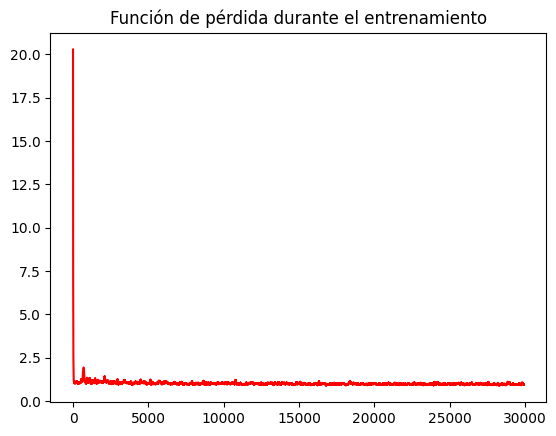

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

# Tamaño del batch de entrenamiento
batch_size = 32

# Tasa de aprendizaje inicial para el gradiente descendente
learning_rate = 1e-3

class Net(torch.nn.Module):
    def __init__(self, input_features, size_hidden = 200, n_output = 1):
        super(Net, self).__init__()
        self.hidden1 = nn.Linear(input_features, size_hidden)
        self.hidden2 = nn.Linear(size_hidden, size_hidden)
        self.out = nn.Linear(size_hidden, n_output)

    def forward(self, x):
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        x = self.out(x)
        return x

# Definimos el modelo del perceptrón
net = Net(13, 200, 1)

# Construimos el optimizador, y le indicamos que los parámetros a optimizar 
# son los del modelo definido: net.parameters()

optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

# Definimos también la función de pérdida a utilizar
criterion = nn.MSELoss()

# Creamos el objeto dataset que empaqueta los array de numpy para que puedan 
# ser leidos por PyTorch
dataset = TensorDataset(torch.from_numpy(X_train).clone(), torch.from_numpy(y_train).clone())

# Creamos un loader iterable indicandole que debe leer los datos a partir de
# del dataset creado en el paso anterior. Este objeto puede ser iterado
# y nos devuelve de a un batch (x, y).
loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)

# Número de épocas
num_epochs = 5000

# Lista en la que iremos guardando el valor de la función de pérdida en cada 
# etapa de entrenamiento
loss_list = []

# Bucle de entrenamiento
for i in range(num_epochs):

    total_loss = 0.0
    for x, y in loader:
        # Seteo en cero los gradientes de los parámetros a optimizar
        optimizer.zero_grad()

        # Realizo la pasada forward por la red
        loss = criterion(net(x), y)
        
        # Realizo la pasada backward por la red        
        loss.backward()
        
        # Actualizo los pesos de la red con el optimizador
        optimizer.step()

        # Me guardo el valor actual de la función de pérdida para luego graficarlo
        loss_list.append(loss.data.item())

        # Acumulo la loss del minibatch
        total_loss += loss.item() * y.size(0)

    # Normalizo la loss total   
    total_loss/= len(loader.dataset)

    # Muestro el valor de la función de pérdida cada 100 iteraciones        
    if i > 0 and i % 100 == 0:
        print('Epoch %d, loss = %g' % (i, total_loss))

# Muestro la lista que contiene los valores de la función de pérdida
# y una versión suavizada (rojo) para observar la tendencia
plt.figure()
loss_np_array = np.array(loss_list)
#plt.plot(loss_np_array, alpha = 0.3)
N = 60
running_avg_loss = np.convolve(loss_np_array, np.ones((N,))/N, mode='valid')
plt.plot(running_avg_loss, color='red')
plt.title("Función de pérdida durante el entrenamiento")

MSE medio en training: 0.9709057
MSE medio en test: 0.94276863


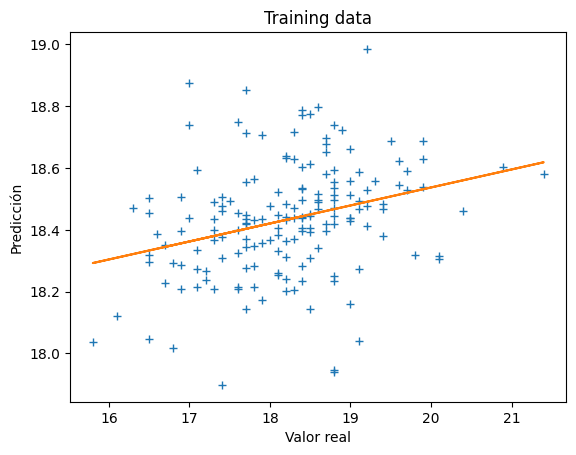

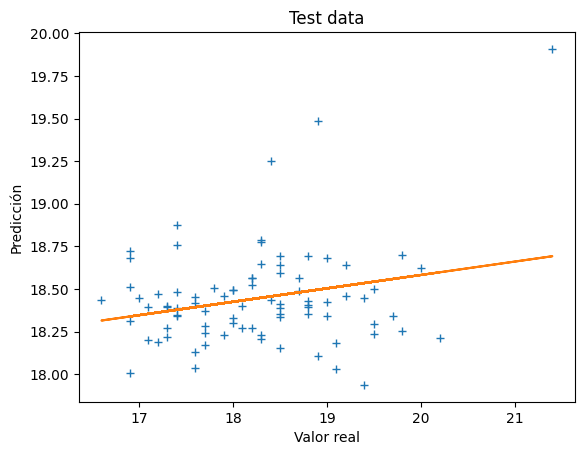

In [23]:
from sklearn.linear_model import LinearRegression
from numpy.linalg import norm

# Definimos un método para mostrar las predicciones como un scatter plot 
# y graficamos la recta de regresión para esos datos.
def plotScatter(x_data, y_data, title, fit_line=True):
  plt.figure()
  
  plt.plot(x_data, y_data, '+')
  plt.xlabel('Valor real')
  plt.ylabel('Predicción')
  plt.title(title)

  if fit_line:
    X, Y = x_data.reshape(-1,1), y_data.reshape(-1,1)
    plt.plot( X, LinearRegression().fit(X, Y).predict(X) )

# Dibujamos el ground truth vs las predicciones en los datos de entrenamiento
py = net(torch.FloatTensor(X_train))
y_pred_train = py.cpu().detach().numpy()
plotScatter(y_train, y_pred_train, "Training data")

# Dibujamos el ground truth vs las predicciones en los datos de test
py = net(torch.FloatTensor(X_test))
y_pred_test = py.cpu().detach().numpy()
plotScatter(y_test, y_pred_test, "Test data")

print ("MSE medio en training: " + str(((y_train - y_pred_train)**2).mean()))
print ("MSE medio en test: " + str(((y_test - y_pred_test)**2).mean()))

# Entregable 
1. Encontrar el mínimo de la función *f* definida en el apartado b). Para ello, deberán encontrar primero la derivada *f'(x)* de forma analítica, y utilizarla para computar el mínimo de la función. Posteriormente, deberán corrobarar que el valor coincida con el que obtuvieron optimizando la función con gradiente descendiente. 

2. Compara el rendimiento de 3 perceptrones multicapa que varíen en la cantidad de neuronas en sus capas intermedia. Probar colocando 2, 10 y 200 neuronas en dichas capas, al entrenar los perceptrones durante 5000 épocas. Mostrar los resultados utilizando:

* los gráficos de dispersión con la recta de regresión
* el error medio en los datos de entrenamiento y test

  Analizar la relación entre dichos resultados y la cantidad de neuronas que posee el perceptrón.
 

In [24]:
criterion = torch.nn.MSELoss(reduction='mean') 
print(type(criterion))


<class 'torch.nn.modules.loss.MSELoss'>
